In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#  Load the train_locations dataset
locations = pd.read_csv("../train/train_locations.csv")

In [3]:
locations.head()

,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823
2,02SFNJH,2,NaN,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,NaN,2.523125,0.733464


In [4]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59503 entries, 0 to 59502
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      59503 non-null  object 
 1   location_number  59503 non-null  int64  
 2   location_type    32294 non-null  object 
 3   latitude         59497 non-null  float64
 4   longitude        59497 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ MB


In [5]:
locations.shape # shape of the dataset

(59503, 5)

In [6]:
locations.describe() # Summary statistics of the dataset

,location_number,latitude,longitude
count,59503.000000,59497.000000,59497.000000
mean,0.753592,2.361135,-25.115410
std,1.355645,22.734109,36.946014
min,0.000000,-1038.149292,-134.415302
25%,0.000000,-0.502593,-78.522567
50%,0.000000,-0.087860,0.021342
75%,1.000000,0.261727,0.514671
max,29.000000,453.653846,45.354231


In [7]:
#  Missing values check
print("\nMissing values per column:")
locations.isnull().sum()


Missing values per column:


customer_id            0
location_number        0
location_type      27209
latitude               6
longitude              6
dtype: int64

In [8]:
locations['location_type'] = locations['location_type'].fillna('Unknown')

In [9]:
#  Value counts for location_type
print("\nLocation Type Counts:")
locations['location_type'].value_counts(dropna=False)


Location Type Counts:


location_type
Unknown    27209
Home       19703
Work        6441
Other       6150
Name: count, dtype: int64

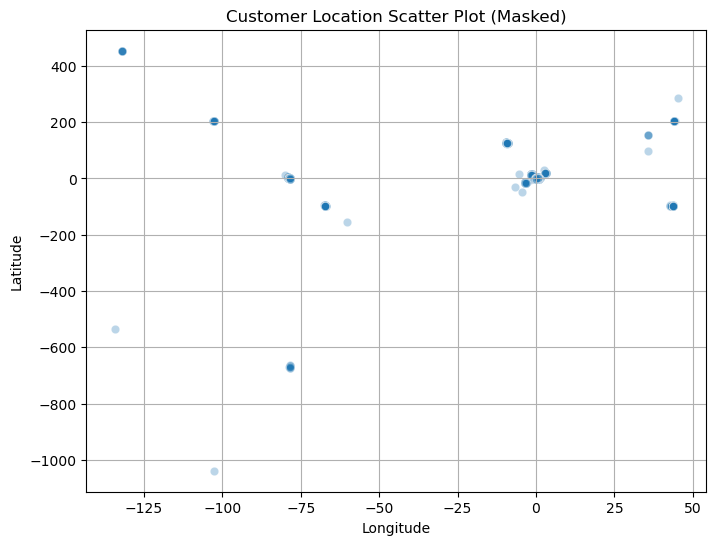

In [10]:
#  Distribution of latitude and longitude
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', data=locations, alpha=0.3)
plt.title('Customer Location Scatter Plot (Masked)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


In [11]:
#  Identify outliers (locations with lat/lon far from typical ranges)
# You can define bounds or use IQR to detect extreme values
lat_q1, lat_q3 = locations['latitude'].quantile([0.25, 0.75])
lon_q1, lon_q3 = locations['longitude'].quantile([0.25, 0.75])

lat_iqr = lat_q3 - lat_q1
lon_iqr = lon_q3 - lon_q1

lat_min = lat_q1 - 1.5 * lat_iqr
lat_max = lat_q3 + 1.5 * lat_iqr
lon_min = lon_q1 - 1.5 * lon_iqr
lon_max = lon_q3 + 1.5 * lon_iqr

In [12]:
# Flag potential GPS noise
locations['is_outlier'] = ~(
    (locations['latitude'] >= lat_min) & (locations['latitude'] <= lat_max) &
    (locations['longitude'] >= lon_min) & (locations['longitude'] <= lon_max)
)

print("\nOutlier Location Counts:")
locations['is_outlier'].value_counts()


Outlier Location Counts:


is_outlier
False    52808
True      6695
Name: count, dtype: int64

In [13]:
locations.head()

,customer_id,location_number,location_type,latitude,longitude,is_outlier
0,02SFNJH,0,Unknown,1.682392,-78.789737,True
1,02SFNJH,1,Unknown,1.679137,0.766823,True
2,02SFNJH,2,Unknown,-0.498648,0.661241,False
3,RU43CXC,0,Home,0.100853,0.438165,False
4,BDFBPRD,0,Unknown,2.523125,0.733464,True


Feature Enginereeing

In [14]:
#  Count number of locations per customer
location_count = locations.groupby('customer_id')['location_number'].nunique().reset_index()
location_count.columns = ['customer_id', 'num_locations']

In [15]:
#  Most common location type per customer
preferred_type = locations.groupby('customer_id')['location_type'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown').reset_index()
preferred_type.columns = ['customer_id', 'preferred_location_type']

In [16]:
# Mean lat/lon (centroid) per customer
mean_location = locations.groupby('customer_id')[['latitude', 'longitude']].mean().reset_index()
mean_location.columns = ['customer_id', 'mean_latitude', 'mean_longitude']

In [17]:
# Merge all engineered features
location_features = location_count.merge(preferred_type, on='customer_id')
location_features = location_features.merge(mean_location, on='customer_id')

In [18]:
location_features.head()

,customer_id,num_locations,preferred_location_type,mean_latitude,mean_longitude
0,000THBA,1,Unknown,-0.020250,0.167026
1,001XN9X,1,Home,0.190209,-78.613388
2,001ZNTK,1,Other,14.075755,-1.613278
3,002510Y,1,Home,0.056822,-78.597624
4,005ECL6,1,Work,-0.315825,0.158935


In [19]:
#  KMeans Clustering on Customer Locations
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [20]:
# Filter valid location rows (exclude outliers if needed)
valid_locations = locations[~locations['is_outlier']].copy()

In [21]:
# Normalize lat/lon for better KMeans performance
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(valid_locations[['latitude', 'longitude']])

In [22]:
# Apply KMeans
k = 8  # You can change this to any reasonable number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
valid_locations['location_cluster'] = kmeans.fit_predict(coords_scaled)

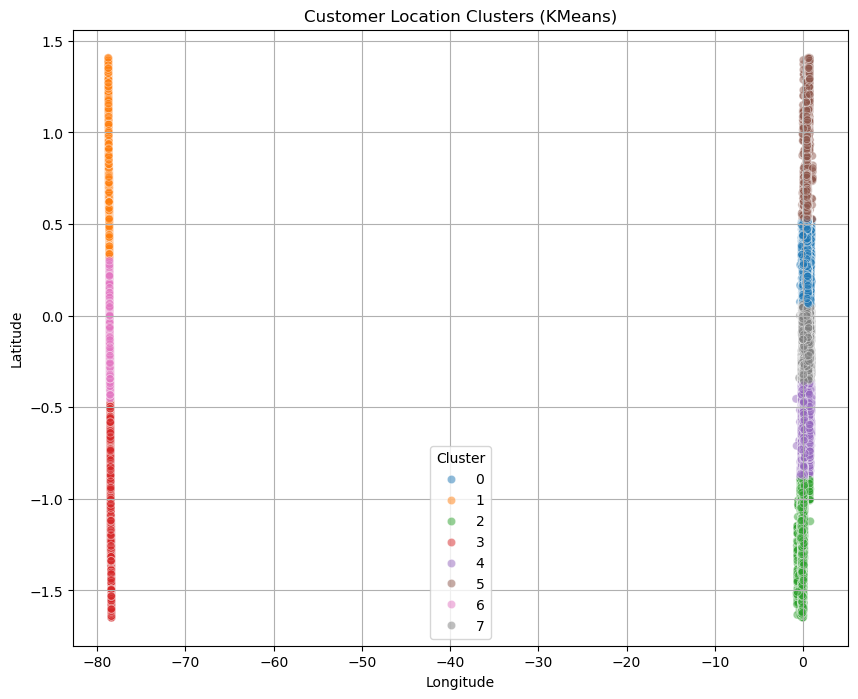

In [24]:
# Visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='longitude', y='latitude', 
    hue='location_cluster',
    palette='tab10',
    data=valid_locations,
    alpha=0.5
)
plt.title('Customer Location Clusters (KMeans)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [25]:
#  Attach dominant cluster to each customer
# Option: Use most frequent cluster per customer
dominant_cluster = valid_locations.groupby('customer_id')['location_cluster'] \
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else -1) \
    .reset_index()
dominant_cluster.columns = ['customer_id', 'dominant_cluster']

In [26]:
# Merge with location_features
location_features = location_features.merge(dominant_cluster, on='customer_id', how='left')

In [27]:
# Preview final features
display(location_features.head())

,customer_id,num_locations,preferred_location_type,mean_latitude,mean_longitude,dominant_cluster
0,000THBA,1,Unknown,-0.020250,0.167026,7.0
1,001XN9X,1,Home,0.190209,-78.613388,6.0
2,001ZNTK,1,Other,14.075755,-1.613278,NaN
3,002510Y,1,Home,0.056822,-78.597624,6.0
4,005ECL6,1,Work,-0.315825,0.158935,7.0
